Asana task: Travel diary survey results on express lane corridors (request from the express lane team)
https://app.asana.com/1/11860278793487/project/12291104512646/task/1211308867058353?focus=true

In [1]:
import geopandas as gpd

# Trip trace conflation work is here: https://github.com/BayAreaMetro/Travel-Diary-Surveys/tree/master/trip-trace-conflation
# The network used for facility segment-to-name matching is this one:
shapefile_path = r"M:\Data\HomeInterview\Bay Area Travel Study 2023\Data\Survey Conflation\OSM_regional_network_convex_hull\bay_area_network.shp"

# Read the shapefile
gdf = gpd.read_file(shapefile_path)

# check the CRS and basic info
print(gdf.crs)

# Display the first few rows
print(gdf.head())

EPSG:3857
       osmid  oneway        highway reversed   length  speed_kph  travel_tim  \
0  157441320       1  motorway_link    False  475.062       87.7        19.5   
1  157807075       1       motorway    False  615.941      104.6        21.2   
2  280274776       1  motorway_link    False   45.062       87.7         1.8   
3  300579876       1  motorway_link    False   40.974       87.7         1.7   
4  499352624       1       motorway    False  351.609      104.6        12.1   

   kilometers lanes     ref  ... maxspeed bridge access junction width tunnel  \
0    0.475062   nan     nan  ...      nan    nan    nan     None   nan    nan   
1    0.615941     3  US 101  ...   65 mph    nan    nan     None   nan    nan   
2    0.045062   nan     nan  ...      nan    nan    nan     None   nan    nan   
3    0.040974   nan     nan  ...      nan    nan    nan     None   nan    nan   
4    0.351609     3  US 101  ...   65 mph    nan    nan     None   nan    nan   

  est_width  area serv

In [2]:
import pandas as pd
pd.set_option('display.max_rows', None)

# review the values under "ref"
gdf["ref"].value_counts()

nan                     528823
CA 82                     1008
CA 1                       743
US 101                     670
CA 12                      484
CA 84                      456
CA 9                       417
CA 116                     413
CA 185                     367
CA 29                      309
CA 35                      275
G4                         274
I 80                       260
J2                         257
G8                         254
CA 128                     250
CA 123                     248
I 680                      243
I 580                      234
CA 238                     234
G6                         218
I 880                      212
CA 61                      194
CA 152                     186
CA 4                       181
I 280                      179
US 40 Historic             172
CA 121                     171
G2                         166
CA 13                      157
G21                        155
J4                         146
CA 92   

In [3]:
# the data is currently in EPSG:3857 i.e., Web Mercator, which uses meters, not degrees.
# That’s the projection used for most web maps (like OpenStreetMap tiles)
# But when we want to filter by latitude and longitude, we need to work in EPSG:4326 (WGS84).

# isolate the I-880 stretch (between 101 and 238)
# the i880 and 238 intercahnge is near San Lorenzo
# the i880 and 101 interchange is near Milpitas
# --------------------------------------------

# Ensure data is in WGS84 (EPSG:4326)
gdf = gdf.to_crs(epsg=4326)

# Get geometry bounds
b = gdf.geometry.bounds  # columns: minx, miny, maxx, maxy

# Define latitude band for I-880 (roughly 101 ↔ 238)
lat_min, lat_max = 37.364353, 37.687824
touches_lat_band = (b["miny"] < lat_max) & (b["maxy"] > lat_min)

# Apply filter for I-880 between 101 and 238
gdf["is_i880_101to238"] = (
    (gdf["highway"] == "motorway")
    & ((gdf["ref"] == "I 880") | (gdf["name"] == "Nimitz Freeway"))
    & touches_lat_band
)

In [4]:
gdf["is_i880_101to238"].value_counts()

False    540724
True        119
Name: is_i880_101to238, dtype: int64

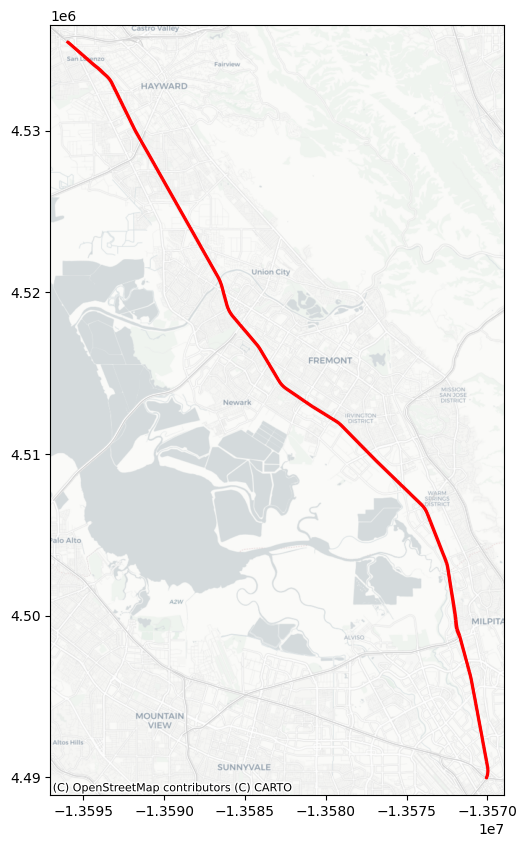

In [5]:
# Visualize it
import matplotlib.pyplot as plt
import contextily as cx

# Convert to Web Mercator for basemap
gdf_3857 = gdf.to_crs(epsg=3857)

# Create figure
fig, ax = plt.subplots(figsize=(10, 10))

# Plot motorway segments in light gray
gdf_3857[gdf_3857["highway"] == "motorway"].plot(ax=ax, color="lightgray", linewidth=0.5)

# Highlight I-880 segment in red
highlight = gdf_3857[gdf_3857["is_i880_101to238"]]
highlight.plot(ax=ax, color="red", linewidth=2)

# Add basemap 
provider = cx.providers.CartoDB.Positron  # or cx.providers.OpenStreetMap.Mapnik
cx.add_basemap(ax, source=provider, zoom=12)

# Automatically zoom to the I-880 extent
if not highlight.empty:
    ax.set_xlim(highlight.total_bounds[0] - 1000, highlight.total_bounds[2] + 1000)
    ax.set_ylim(highlight.total_bounds[1] - 1000, highlight.total_bounds[3] + 1000)


In [ ]:
# create a new column named Facility
gdf.loc[gdf["is_i880_101to238"], "Facility"] = "i880_101to238"

# filter to only rows with "i880_101to238"
gdf_filtered = gdf[gdf["Facility"] == "i880_101to238"]
len(gdf_filtered)

In [ ]:
# output
output_path = r"E:\Box\Modeling and Surveys\Surveys\Travel Diary Survey\BATS_2023\Data\2023\Survey Conflation\osmid_Facilityi880_101to238.csv"

# select only the desired columns and export
gdf_filtered[['osmid', 'Facility']].to_csv(output_path, index=False)